# Extraction and exploration of Cognite OID

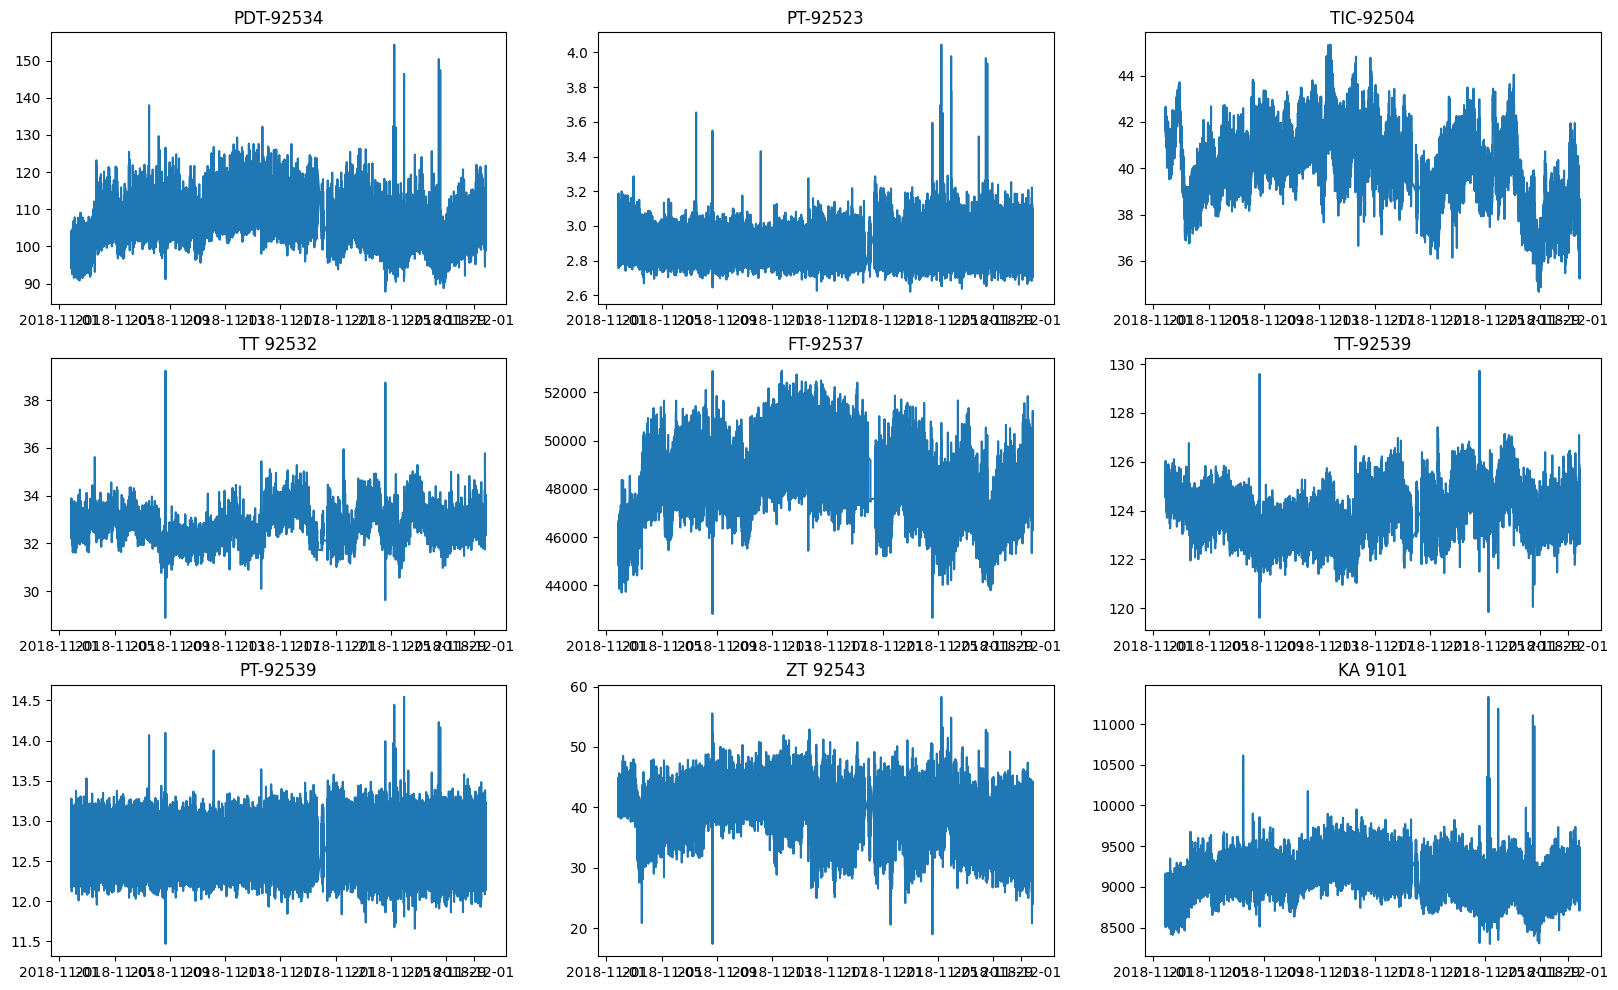

In [63]:
from publicdata import client as c
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import pandas as pd

# Nine sensors related to the inputs, outputs and controls of a compressor subsystem.
# Dictionary made with key=name of sensor and value=Id of sensor
sensors = {
    'PDT-92534': 6908033636680653,
    'PT-92523':8877482139815959,
    'TIC-92504':7012228881452176,
    'TT 92532':8152209984966682,
    'FT-92537':3278479880462408,
    'TT-92539':643849686863640,
    'PT-92539':1890487216163163,
    'ZT 92543':4146236330407219,
    'KA 9101':844472910348820
}
# I'll extract a pandas dataframe for each of the sensors in sensor_names, and these will be stored
# in the following dictionary, again with the sensor name as the key.
dfs_dict = {}

startdate = datetime(2018, 11, 1)
enddate = datetime(2018, 12, 1)
today = datetime.today()
days_since_start = (today - startdate).days
days_since_end = (today - enddate).days
starttime = f'{days_since_start}d-ago' # Start time of the interval I want to extract
endtime = f'{days_since_end}d-ago' # End time of the interval I want to extract

# Extract dataframes from Cognite OID and store them in the dfs_dict dictionary
for k, v in sensors.items():
    res = c.time_series.data.retrieve_dataframe(id=v, 
                                                start=starttime, 
                                                end=endtime, 
                                                column_names='id', 
                                                granularity = "60s",
                                                aggregates=["average"])
    # Need to find a way to grab the unit of the time-series
    dfs_dict[k] = res

def plot_sensor_data(name):
    plt.plot(dfs_dict[name], label=name)
    plt.legend()
    plt.show()

def plot_all_nine_sensors(dataframe = dfs_dict):
    plt.figure(figsize=(20, 12))
    rows = 3
    cols = 3
    n = rows * cols
    index = 1
    for name, df in dataframe.items():
        plt.subplot(rows, cols, index)
        index += 1
        plt.plot(df)
        plt.title(name)

# plot_sensor_data('PT-92523')
plot_all_nine_sensors()


### Simple inspection of the data

In [64]:
print(dfs_dict["ZT 92543"])

                     4146236330407219|average
2018-11-01 20:44:43                 43.138162
2018-11-01 20:45:43                 43.007844
2018-11-01 20:46:43                 42.171592
2018-11-01 20:47:43                 40.390653
2018-11-01 20:48:43                 39.788092
...                                       ...
2018-12-01 20:40:43                 30.908207
2018-12-01 20:41:43                 29.559283
2018-12-01 20:42:43                 28.355196
2018-12-01 20:43:43                 24.765469
2018-12-01 20:44:43                 28.131204

[41666 rows x 1 columns]


### Standardizing the data

PDT-92534: Avg: 106.1144830614807 Std: 5.269687898045912 Shape: (41939, 1)
PT-92523: Avg: 2.8835003607109475 Std: 0.08184082859281874 Shape: (41936, 1)
TIC-92504: Avg: 39.95643773722786 Std: 1.5472432309419482 Shape: (41930, 1)
TT 92532: Avg: 32.814222762793 Std: 0.7091767119789287 Shape: (41444, 1)
FT-92537: Avg: 48026.85011228226 Std: 1373.9727926225307 Shape: (41999, 1)
TT-92539: Avg: 124.09514468869604 Std: 0.8975021338252106 Shape: (41537, 1)
PT-92539: Avg: 12.692973579758585 Std: 0.2442905992105178 Shape: (41934, 1)
ZT 92543: Avg: 38.78172202630313 Std: 3.5963991075596873 Shape: (41666, 1)
KA 9101: Avg: 9102.808048871928 Std: 188.72361119362532 Shape: (41892, 1)


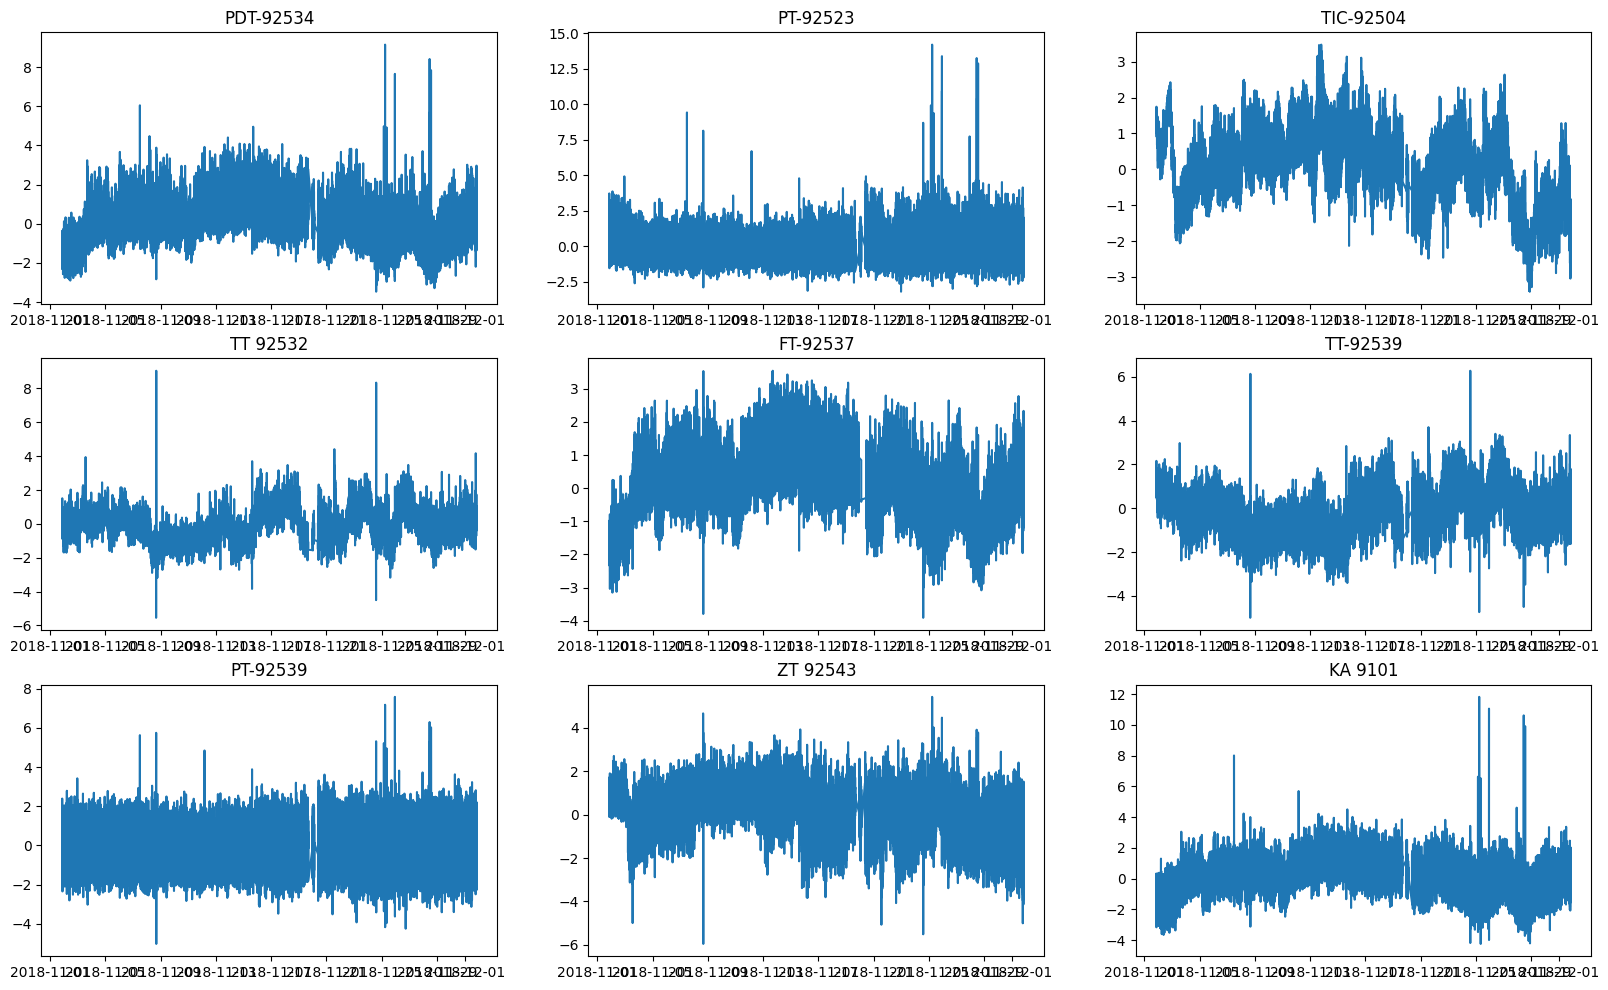

In [65]:
import numpy as np

standard_df = {}
# k = 6 #width of the range of accepted values

for name, df in dfs_dict.items():
    avg = df.mean().iloc[0]
    std = df.std().iloc[0]
    tmp_df = (df-avg)/std
    print(f'{name}: Avg: {avg} Std: {std} Shape: {tmp_df.shape}')

    # upper = k*std
    # lower = -k*std

    # # Create arrays of Boolean values indicating the outlier rows
    # upper_array = tmp_df.index[tmp_df[tmp_df.columns[0]] >= upper].tolist()
    # lower_array = tmp_df.index[tmp_df[tmp_df.columns[0]] <= lower].tolist()
    
    # # Removing the outliers
    # tmp_df.drop(index=upper_array, inplace=True)
    # tmp_df.drop(index=lower_array, inplace=True)
    
    # Print the new shape of the DataFrame
    # print("New Shape: ", tmp_df.shape)
    standard_df[name] = tmp_df

plot_all_nine_sensors(dataframe=standard_df)

### Compile and plot histograms for each sensor

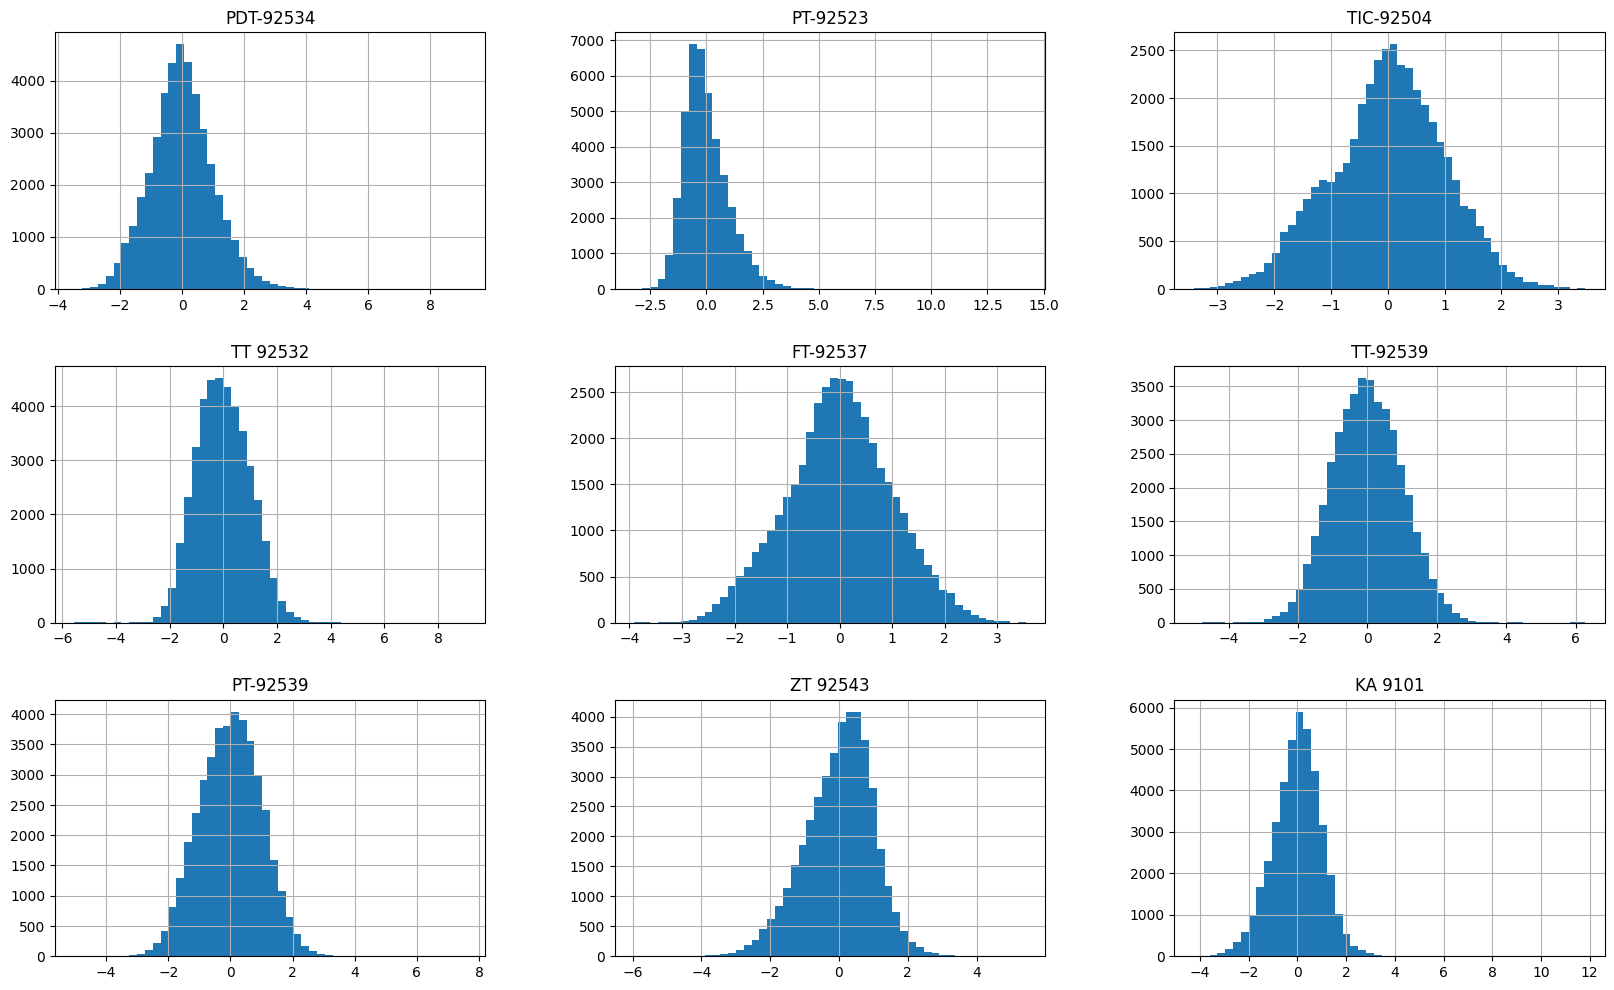

In [66]:
#Plot histograms
#Using standardized values
names = list(standard_df.keys())
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
bins = 50

m=0
for i in range(3):
    for j in range(3):

        standard_df[names[m]].hist(bins = bins, ax=ax[i,j], figsize=(20, 18))
        ax[i,j].set_title(names[m])
        m+=1



### Finding KL divergence by comparing histograms

Note: you may need to restart the kernel to use updated packages.
[[0.0, inf, 1.350690738065759, inf, 1.9120494959444636, 1.97765352869999, inf, inf, inf], [inf, 0.0, 2.7464495500155515, 5.0532399281377645, 3.9876105817455616, inf, inf, inf, inf], [inf, inf, 0.0, inf, 0.04060433864030326, inf, inf, inf, inf], [inf, inf, 0.774143603751035, 0.0, 0.9181258466594718, inf, inf, inf, inf], [inf, inf, 0.029233419594659835, inf, 0.0, inf, inf, inf, inf], [inf, inf, 0.2902429756954598, inf, 0.3370642243237688, 0.0, inf, inf, inf], [inf, inf, 0.5432338179754942, inf, 0.664110548734999, inf, 0.0, inf, inf], [inf, inf, 0.20708092879683146, inf, 0.15511679277488027, inf, inf, 0.0, inf], [inf, inf, 1.6206691363596548, inf, 2.19065013976027, 2.293767208881746, inf, inf, 0.0]]


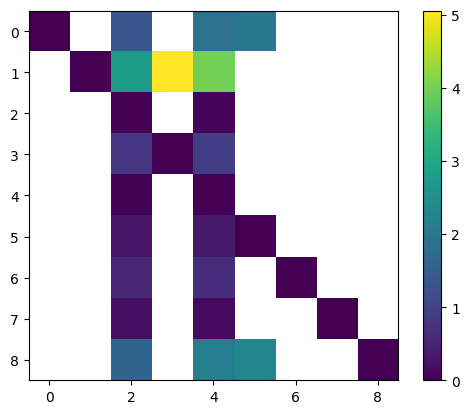

In [67]:
%pip install scipy
from scipy.stats import entropy
import numpy as np
KL = []

i = 0
j = 0

for name, df in standard_df.items():
    row = []
    hist1 = np.histogram(df, bins=bins)[0]
    hist1 = hist1/sum(hist1)
    for name2, df2 in standard_df.items():
        hist2 = np.histogram(df2, bins=bins)[0]
        hist2 = hist2/sum(hist2)
        # print(f'H1: {type(hist1)}, H2: {type(hist2)}')
        row.append(entropy(hist1, hist2))
    KL.append(row)

print(KL)
im = plt.imshow(KL)
plt.colorbar(im)
plt.show()

### Finding KL divergence from mean and std

We assume that each sensors samples comes from a univariate normal distribution with mean $\mu$ and standard deviation $\sigma$, we can estimate $\mu$ and $\sigma$ from the sample date. We can thn find the KL divergence between 2 estimated distributions by the following formula

$$KL(\mathcal{N}_1(\mu_1, \sigma_1)||\mathcal{N}_2(\mu_2, \sigma_2)) = log(\frac{\sigma_2}{\sigma_1}) + \frac{\sigma_1^2 +(\mu_1-\mu_2)^2}{2 \sigma_2^2}-\frac{1}{2}$$

In [68]:
import numpy as np
from scipy.stats import entropy

def KL_with_params(m1, std1, m2, std2):
    return np.log(std2/std1)+(std1**2 + (m1-m2)**2)/(2*std2**2)-1/2

# Test the function
mu, sigma = 1, 2
mu2, sigma2 = 0, 2

print(f'Using mean and std directly: KL={KL_with_params(mu, sigma, mu2, sigma2)}')

Using mean and std directly: KL=0.125


Since this method assumes the mean and standard deviation comes from actual normal distributions, standardizing the samples would make all the sample distributions look identical. We therefore have to us unstandardized values with this KL divergence method. Since it's just estimates of mean and standard deviation, the computed KL divergence will not be the actual KL divergence between the sensors behavior, but rather the KL divergence between the sensors estimated source distributions.

[[0.0, 797586.4861978965, 918.2258810618413, 5366.711261646649, 613.2834897045628, 215.65006892415838, 73351.46043337871, 175.45319463055682, 1139.35352757328], [195.5409304061814, 0.0, 289.49697692964673, 892.2921955970658, 620.0717134364735, 9121.749313690932, 806.8591161883761, 53.10046254602571, 1169.7436625461078], [79.57573654483122, 102774.4673875938, 0.0, 51.813769964908516, 616.1895220664971, 4394.751380399416, 6245.280793272824, 0.4893487295398192, 1157.3515230546284], [98.25582786713352, 66909.97259422543, 11.03931336537073, 0.0, 617.1512116748852, 5172.054171855756, 3394.73021596267, 2.5196613196032023, 1159.949716138782], [41381285.563508414, 172306383785.7998, 481342247.8785502, 2291877497.5415883, 0.0, 1425532577.7366772, 19330834422.628788, 89095675.02306776, 21293.32620234119], [7.105801379292519, 1096835.04470389, 1478.7916987160045, 8283.703239654773, 614.5972504817474, 0.0, 103983.50896960885, 282.2834993528802, 1136.5859137725265], [159.71505739138968, 7186.1173134

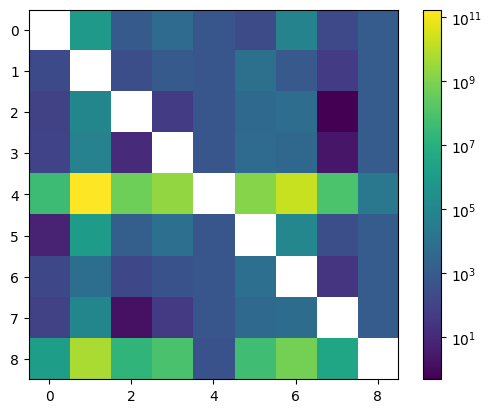

In [69]:
from matplotlib import colors
KL2 = []

for name, df in dfs_dict.items():
    avg1 = df.mean().iloc[0]
    std1 = df.std().iloc[0]
    row = []
    for name, df in dfs_dict.items():
        avg2 = df.mean().iloc[0]
        std2 = df.std().iloc[0]
        kl_tmp = KL_with_params(avg1, std1, avg2, std2)
        row.append(kl_tmp)
    KL2.append(row)

print(KL2)
im = plt.imshow(KL2, norm=colors.LogNorm())
plt.colorbar(im)
plt.show()

### Correlation between sensors

In [72]:
# %pip install jinja2
all_dfs = pd.DataFrame()
for name, df in standard_df.items():
    all_dfs[name] = df

corr = all_dfs.corr()
corr.style.background_gradient(cmap='Spectral')

# This is most likely problematic because of the varying lengths of the time series


/home/fredrik/time_series_gan_project/.venv/lib/python3.9/site-packages/pandas/io/formats/style.py:3819: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/fredrik/time_series_gan_project/.venv/lib/python3.9/site-packages/pandas/io/formats/style.py:3820: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,PDT-92534,PT-92523,TIC-92504,TT 92532,FT-92537,TT-92539,PT-92539,ZT 92543,KA 9101
PDT-92534,1.000000,nan,nan,nan,nan,nan,nan,nan,nan
PT-92523,nan,nan,nan,nan,nan,nan,nan,nan,nan
TIC-92504,nan,nan,nan,nan,nan,nan,nan,nan,nan
TT 92532,nan,nan,nan,nan,nan,nan,nan,nan,nan
FT-92537,nan,nan,nan,nan,nan,nan,nan,nan,nan
TT-92539,nan,nan,nan,nan,nan,nan,nan,nan,nan
PT-92539,nan,nan,nan,nan,nan,nan,nan,nan,nan
ZT 92543,nan,nan,nan,nan,nan,nan,nan,nan,nan
KA 9101,nan,nan,nan,nan,nan,nan,nan,nan,nan
